<a href="https://colab.research.google.com/github/LucioFassarella/SimulacoesComputacionaisQuanticas/blob/main/Qiskit_SimulacaoSpin1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qiskit

---

<font color = "yellow">**Qiskit**:</font>
*   [Python's Instalation](https://pypi.org/project/qiskit/)
*   [IBM Quantum cloud](https://quantum.cloud.ibm.com/)
    *   [Qiskit connect](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-get-started) (IBM Runtime Service)
       *   [Getting Started](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-get-started)
*   [Qiskit](https://docs.quantum.ibm.com/api/qiskit)
    *   [Qiskit Circuit Library](https://docs.quantum.ibm.com/api/qiskit/circuit_library)
    *   [Qiskit Gates Tutorial](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits/3_summary_of_quantum_operations.ipynb)
    *   [List of Quantum Logic Gates](https://en.wikipedia.org/wiki/List_of_quantum_logic_gates)

[<font color="yellow">**Execution modes**</font>](https://quantum.cloud.ibm.com/docs/en/guides/execution-modes)
*	[Choose the execution mode](https://quantum.cloud.ibm.com/docs/en/guides/choose-execution-mode)
*   [Single Job](https://quantum.cloud.ibm.com/docs/en/guides/primitives-examples#estimator-examples)
*	[Batch mode](https://quantum.cloud.ibm.com/docs/en/guides/run-jobs-batch)
*	[Section mode](https://quantum.cloud.ibm.com/docs/en/guides/run-jobs-session)
*	[Primitives examples](https://quantum.cloud.ibm.com/docs/en/guides/primitives-examples)


[<font color="yellow">**Local simulators**</font>](https://quantum.cloud.ibm.com/docs/en/migration-guides/local-simulators)

---

⏬

## <font color = "orange">Introdução à Computação Quântica</font>







## QISKIT: Carregamento

In [5]:
!pip install qiskit -U
!pip install qiskit_aer -U
!pip install qiskit-ibm-runtime -U

!pip install matplotlib
!pip install pylatexenc

import qiskit
qiskit.__version__

'2.2.3'

In [7]:
# Qiskit: métodos básicos

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit import transpile

from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city

## Método de Primitivos



In [8]:
def qiskit_sampler(circuito_com_medidas, shots = None, backend = None):
    '''
    Método para executar o Sampler
    >>> O Sampler realiza medidas em circuitos quânticos e retorna a contagem de qubits.
        A partir dos resultados do Sampler, podemos estimar as probabilidade de cada resultado.

    Input:
        circuito : circuito quântico que prepara um estado de qubits
        backend  : backend para rodar o Sampler

    Saída:
        resultado do Sampler

    Observação: os resultados do Sampler são rotulados pelo nomes dos registros clássicos.
                Para um circuito com medidas definidas por 'measure_all', o rótulo é 'meas'.
                Para circuitos com medidas definidas de início sem denominação explícita,
                os rótulos são 'c', 'c1', 'c2', etc.

    Tutorial do Sampler: https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/sampler-v2
    '''

    # Importação de métodos e backend

    from qiskit_ibm_runtime import SamplerV2 as Sampler

    if backend is None:
        from qiskit_ibm_runtime.fake_provider import FakeBrisbane
        backend = FakeBrisbane()
    else:
        backend = backend

    from qiskit.transpiler import generate_preset_pass_manager
    pm = generate_preset_pass_manager(optimization_level=2, backend = backend)

    # Transpilação

    isa_circuitos = pm.run(circuito_com_medidas)

    if shots is None:
        shots = 2**10
    else:
        shots = shots

    sampler = Sampler(backend)
    job = sampler.run([(isa_circuitos, )], shots = shots)
    result = job.result()
    counts = result[0].data['c'].get_counts()

    return counts, result

def qiskit_estimator(circuito_sem_medidas, hamiltoniano, precisao = None, backend = None):
    '''
    Método para executar o Estimator
    >>> O Estimator estima valores esperados de circuitos e observáveis.

    Input:
        circuito : circuito quântico que prepara um estado de qubits
        hamiltoniano (SparsePauliOp): hamiltoniano a ser medido
        precisao (float): precisão do resultado
        backend  : backend para rodar o Estimator

    Saída:
        resultado do Estimator

    Tutorial do EstimatorV2: https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/estimator-v2
    '''

    # Importação de métodos e backend

    from qiskit_ibm_runtime import EstimatorV2 as Estimator
    from qiskit.transpiler import generate_preset_pass_manager

    # Use the existing service object
    # service = QiskitRuntimeService()
    if backend is None:
        from qiskit_ibm_runtime.fake_provider import FakeBrisbane
        backend = FakeBrisbane()
    else:
        backend = backend

    if precisao is None:
        precisao = 2**(-10)
    else:
        precisao = precisao

    # Transpilação

    pm = generate_preset_pass_manager(backend = backend, optimization_level=1)
    isa_circuito = pm.run(circuito_sem_medidas)
    isa_hamiltoniano = hamiltoniano.apply_layout(isa_circuito.layout)

    # Estimator:

    estimator = Estimator(mode=backend)

    # Job

    job = estimator.run([(isa_circuito, isa_hamiltoniano, )], precision = precision)

    pub_result = job.result()[0]

    return pub_result.data.evs

# Simulação de Spin-1/2

*   Fonte: Émerson M. Alves *et al.*: *Simulating single-spin dynamics on an IBM five-qubit chip*. Rev. Bras. Ensino Fís., v.42 (2020). [DOI:10.1590/1806-9126-RBEF-2019-0299](https://www.scielo.br/j/rbef/a/B7wZXnYHXcWPGfPy8SjZs6w/?lang=en).

**Equação de Schrödinger**

$$
i\hbar \frac{\partial}{\partial t} |\psi(t)\rangle = H(t)|\psi(t)\rangle .
$$

**Hamiltoniano** proveniente de campo magnético:

$$
H(t) = \frac{\hbar \omega_0}{2} \sigma_z + \frac{\hbar \omega_r}{2} \left\lbrack \cos(\omega t)\sigma_x + \sin(\omega t)\sigma_y \right\rbrack.
$$
<font color="gray"> **Dedução do Hamiltoniano** devido à interação do spin-1/2 com campo magnético externo.

Operador momento magnético do spin-1/2:
$$
\begin{split}
\vec{\mu} &= \frac{\gamma \hbar}{2} \vec{\sigma};\ \ \vec{\sigma} = \sigma_x \hat{x} + \sigma_y \hat{y} + \sigma_z\ \hat{z};\\
\gamma &: \text{fator giromagnético (característico da partículas carregadas)}.
\end{split}
$$
Campo magnético externo:
$$
\begin{split}
\vec{B} &= B_0 \hat{z} + B_r\left\lbrack \cos(\omega t)\hat{x} + \sin(\omega t)\hat{y}\right\rbrack;\\
B_0 &: \text{intensidade do campo magnético vertical};\\
B_r &: \text{intensidade do campo magnético transversal}\\
\omega &: \text{frequência de rotação do campo magnético transversal}.
\end{split}
$$
Hamiltoniano:
$$
\begin{split}
H(t) &= - \vec{\mu} \cdot \vec{B}(t)\\
&= \frac{\hbar \omega_0}{2} \sigma_z + \frac{\hbar \omega_r}{2} \left\lbrack \cos(\omega t)\sigma_x + \sin(\omega t)\sigma_y \right\rbrack,
\end{split}
$$
onde
Aqui,  , enquanto $\omega_0$ e $\omega_r$ são frequências característica da iteração campo-partícula:
$$
\begin{split}
\omega_0 &= - \frac{\gamma B_0}{\hbar}\ \ \text{(frequência de Larmor)};\\
\omega_r &= - \frac{\gamma B_r}{\hbar}\ \ \text{(acoplamento spin-campo transversal)}.
\end{split}
$$
</font>
⏬
## Estado dependente do tempo:
$$
| \psi(t)\rangle = e^{-i\frac{\omega}{2}t \sigma_z}e^{-i\frac{\tilde{H}}{\hbar}t} | \psi(0)\rangle,
$$
onde
$$
\tilde{H} = \hbar \frac{\omega_0 - \omega}{2}\sigma_z + \hbar \frac{\omega_r}{2}\sigma_x.
$$
**Operador-evolução**:
$$
\begin{split}
U_0(t) &= e^{-i\frac{\omega}{2}t \sigma_z} = e^{-\frac{i\omega t}{2}}%
\begin{pmatrix}
1 & 0\\
0 & e^{i\omega t}
\end{pmatrix}\\
\ \\
U_{xz}(t) &= e^{-i\frac{\tilde{H}}{\hbar}t} = %
\begin{pmatrix}
\cos(\Omega t/2) + i \frac{\Delta}{\Omega} \sin(\Omega t/2) & i\frac{\omega_r}{\Omega}\sin(\Omega t/2)\\
 i\frac{\omega_r}{\Omega}\sin(\Omega t/2) & \cos(\Omega t/2) - i \frac{\Delta}{\Omega} \sin(\Omega t/2)
\end{pmatrix}
\end{split}
$$
e
$$
\Delta = \omega_0 - \omega;\ \ \Omega = \sqrt{\Delta^2 + \omega_r^2}.
$$

## Trotterização de $$U_{xz}(t) = e^{-i\tilde{H}t/\hbar}$$

$$
\begin{split}
U_{xz}(t) &= e^{-i\tilde{H}t/\hbar}\\
            &= e^{-i\frac{\Delta t}{2} \sigma_z - i\frac{\omega_r t}{2}\sigma_x}
\end{split}
$$


## **Fenômeno de Ressonância**: situação em que a frequência do campo transversal igual à frequência de Larmor


Condição de frequência do campo transversal é igual à frequência de Larmor:

$$
\omega = \omega_0 \leadsto \Delta = 0\ \ \&\ \ \Omega = |\omega_f|.
$$
Nessa situação:
$$
\begin{split}
U_0(t) &=%  
\begin{pmatrix}
1 & 0\\
0 & e^{i\omega t}
\end{pmatrix}%
\ \ \ (\text{descartando a fase global});\\
\ \\
U_f^{res}(t) &= %
\begin{pmatrix}
\cos(\omega_r t/2)  & i\sin(\omega_r t/2)\\
 i\sin(\omega_r t/2) & \cos(\omega_r t/2)
\end{pmatrix};
\end{split}
$$
e
$$
|\psi(t)\rangle = U_0(t)U_{xz}^{res}(t)|\psi(0)\rangle.
$$

Para a simulação Q-computacional, exprimimos cada parte do operador evolução em termos de portas quânticas de 1-qubit:
$$
\begin{split}
U_0(t) &= P(\omega t);\\%
U_f^\textrm{eff}(t) &= U3\left(\omega_f t,\frac{\pi}{2},-\frac{\pi}{2}\right),
\end{split}
$$
sendo
$$
\begin{split}
P(\theta) &= \begin{bmatrix}
	1 & 0\\
	0 &e^{i\theta}
\end{bmatrix}\ \ \ \ \ \text{(operador de fase)};\\%
U3(\theta,\phi, \lambda) &= \begin{bmatrix}
	\cos(\theta/2) & -e^{i\lambda} \sin(\theta/2)\\
	e^{i\phi}\sin(\theta/2) & e^{i(\phi + \lambda)}\cos(\theta/2)
\end{bmatrix}\ \ \ \ \ \text{(operador unitári geral)}.
\end{split}
$$
Portanto,
$$
|\psi(t)\rangle = P(\omega t)U3\left(\omega_f t,\frac{\pi}{2},-\frac{\pi}{2}\right)|\psi(0)\rangle.
$$
Para a condição inicial
$$
|psi(0)\rangle = |0\rangle,
$$
temos:
$$
|\psi(t)\rangle = P(\omega t)U3\left(\omega_f t,\frac{\pi}{2},-\frac{\pi}{2}\right)|\psi(0)\rangle
$$
e
$$
\mathcal{M}_z(t) = \frac{\hbar}{2}\cos(\omega t).
$$

---

*	Qiskit: <i>How do I use parameterized circuits in Qiskit? 1 Minute Qiskit</i>. Youtube, 17 ago. 2020. URL: [https://youtu.be/adeYx7bwYrA?si=rgT9Gnmk_6k7G1ty](https://youtu.be/adeYx7bwYrA?si=rgT9Gnmk_6k7G1ty).

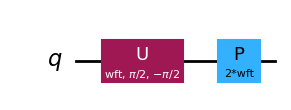

Hamiltoniano: Z


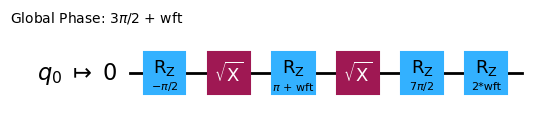

In [13]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler import generate_preset_pass_manager

from qiskit.circuit import Parameter
import numpy as np

# Backend
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
backend = FakeBrisbane()

# Construção do circuito parametrizado por  wt e wft

wt = Parameter("wt")
wft = Parameter("wft")

ratio = 2 # razão w/wf

qc = QuantumCircuit(1)
qc.u(wft, np.pi/2, -np.pi/2, 0)
qc.p(ratio*wft, 0)

display(qc.draw('mpl'))

# Hamiltoniano

from qiskit.quantum_info import Pauli, SparsePauliOp

sigmaz = Pauli("Z")
print(f"Hamiltoniano: {sigmaz}")

# Transpilação

pm = generate_preset_pass_manager(backend = backend, optimization_level=1)
qc_transpilado = pm.run(qc)
hamiltoniano_transpilado = sigmaz.apply_layout(qc_transpilado.layout)

display(qc_transpilado.draw('mpl'))


In [14]:
# Estimator:
estimator = Estimator(mode=backend)
precisao = 2**(-10)

# Definição da função que calcula o valor esperado da magnetização

def magnetizacao(wft_ = float, precisao = None):
    '''
    Função que calcula o valor esperado da magnetização

    Input:
        wft (float)...: frequência de rotação do campo magnético transversal
    Output:
        magnetizacao (float): valor esperado da magnetização
    '''

    if precisao is None:
        precisao = 2**(-10)
    else:
        precisao = precisao

    # Circuito com parâmetro numérico

    qc_transpilado_numerico = qc_transpilado.assign_parameters({wft: wft_})

    # Job
    job = estimator.run([(qc_transpilado_numerico, hamiltoniano_transpilado, )], precision = precisao)
    pub_result = job.result()[0]

    return pub_result.data.evs

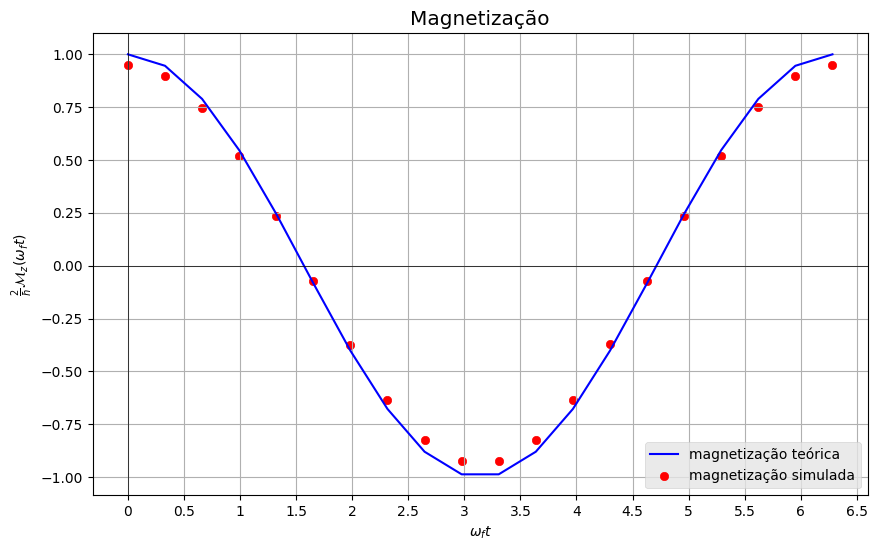

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# Define the function to plot

# Generate x values
wft_values = np.linspace(0, 2*np.pi, 20)

# Magnetização teórica
def magnetizacao_teorica(wft):
    return np.cos(wft)
y_teorico = [magnetizacao_teorica(wft) for wft in wft_values]

# Magnetização simulada:
y_simulado = [magnetizacao(wft, 2**(-10)) for wft in wft_values]

# Create the plot
#plt.figure(figsize=(10, 6))

f,ax = plt.subplots(figsize = (10,6))
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
plt.style.use("ggplot")


ax.plot(wft_values, y_teorico, label='magnetização teórica', color = 'blue')
ax.scatter(wft_values, y_simulado, label='magnetização simulada', color = 'red')
plt.title('Magnetização')
plt.xlabel(r'$\omega_f t$')
plt.ylabel(r'$\frac{2}{\hbar} \mathcal{M}_z(\omega_f t)$')
ax.grid(True)
ax.legend()
ax.axhline(0, color='black',linewidth=0.5)
ax.axvline(0, color='black',linewidth=0.5)

plt.show()

## Evolução temporal da componente $Z$-spin

$$
\mathcal{M}_z(t) = \langle\psi(t) | S_z | \psi(t) \rangle = \frac{\hbar}{2}\cos(\omega_r t).
$$

**Precessão de Spin**

Estado inicial:

$$
\begin{split}
| \psi_0\rangle := \cos\left(\frac{\theta}{2}\right) | \uparrow \rangle + \sin\left(\frac{\theta}{2}\right) |\downarrow \rangle
\end{split}
$$

$$
|\psi(t)\rangle = P(\omega t)U3\left(\omega_f t,\frac{\pi}{2},-\frac{\pi}{2}\right)| \psi_0\rangle .
$$

Momento magnético de Spin:
$$
\begin{split}
\vec{\mathcal{M}}(t) &= \mathcal{M}_z\hat{z} + \vec{\mathcal{M}}_{xy}(t)\\
	&=  \frac{\hbar}{2}\cos(\theta)\hat{z} + \frac{\hbar}{2} \sin(\theta)\left\lbrack \cos(\omega_0 t)\hat{x} + \sin(\omega_0 t)\hat{y} \right\rbrack
\end{split}
$$

$$
|\omega_r| \ll |\omega_0|
$$